In [1]:
'''
experiment - shortest path MDP
'''
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import agent
import room as fl
import utils

# pretify
sns.set_style('whitegrid')

In [2]:
'''
data structures to store the results
'''
log = pd.DataFrame(columns=['algorithm',
                           'average-reward/time-step'])

In [3]:
'''
experiment setting
'''
# make the game to get details
game = fl.make_game()
mobs = game.its_showtime()

# parameters
num_experiments = 10
world_param = fl.get_params()
num_states = world_param['num_states']
num_actions = world_param['num_actions']
len_episodes = 100
discount = 0.9
# reward function
reward = np.zeros((num_states, num_actions))
goal_loc = utils.get_location(mobs, 'X')
# in all the following cases, we have 100 -> enters the goal state
reward[goal_loc+1, 0] = 100
reward[goal_loc-1, 1] = 100
reward[goal_loc+11, 2] = 100
reward[goal_loc-11, 3] = 100
# start distribution - always current start location
start_loc = utils.get_location(mobs, 'O')
start_dist = np.zeros(num_states)
start_dist[start_loc] = 1

# transition distribution (just alpha counts)
alpha = np.zeros((num_states, num_states, num_actions))
# go through all states
for state in range(num_states):
    # change if it is not a wall
    if not utils.is_wall(state, mobs):
        # if there is no wall, give 1
        if not utils.is_wall(state-1, mobs):
            alpha[state-1, state, 0] = 1
        else:  # stay if there is wall
            alpha[state, state, 0] = 1

        if not utils.is_wall(state+1, mobs):
            alpha[state+1, state, 1] = 1
        else:  # stay if there is wall
            alpha[state, state, 1] = 1

        if not utils.is_wall(state-11, mobs):
            alpha[state-11, state, 2] = 1
        else:  # stay if there is wall
            alpha[state, state, 2] = 1

        if not utils.is_wall(state+11, mobs):
            alpha[state+11, state, 3] = 1
        else:  # stay if there is wall
            alpha[state, state, 3] = 1
    else: # if inside wall, you will stay inside wall
        alpha[state, state, :] = 1

In [4]:
'''
Solving MDP using Policy Iteration - 10 Iterations
'''
# initialize policy to local minima
# 0 - left
# 1 - right
# 2 - up
# 3 - down
det_policy = np.zeros(num_states)
det_policy[24] = 3
det_policy[35] = 3
det_policy[46] = 3
det_policy[57] = 1
det_policy[58] = 1
det_policy[59] = 1
det_policy[60] = 1
det_policy[61] = 1
det_policy[62] = 1
det_policy[63] = 2
det_policy[52] = 2
det_policy[41] = 2
det_policy[30] = 2

for _ in tqdm(range(num_experiments)):
    # initialize total_reward
    total_reward = 0
    # create agent
    bond = agent.PoliQ(num_actions,
                      num_states,
                      discount,
                      len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    # use the same initial suboptimal policy
    bond.policy = np.copy(det_policy)

    # perform inference
    bond.learn(niter=10)  # 0 -> till convergence

    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_location(obs, char='O'))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-PI-10",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)
    
# print final policy
print(np.reshape(np.round(bond.policy, 2), (9,11)))


[[0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 3 0 0]
 [0 0 1 2 0 0 0 1 3 0 0]
 [0 0 0 2 0 0 0 1 0 0 0]
 [0 0 1 3 0 0 0 1 2 0 0]
 [0 1 1 1 1 1 1 1 2 0 0]
 [0 0 1 1 1 1 1 1 2 0 0]
 [0 0 0 1 1 1 1 1 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [5]:
'''
Solving MDP using GD - 100 iterations, step_size=0.001
'''
# initialize policy to local minima
sto_policy = np.ones((num_actions, num_states))
sto_policy[3, 24] = 10
sto_policy[3, 35] = 10
sto_policy[3, 46] = 10
sto_policy[1, 57] = 10
sto_policy[1, 58] = 10
sto_policy[1, 59] = 10
sto_policy[1, 60] = 10
sto_policy[1, 61] = 10
sto_policy[1, 62] = 10
sto_policy[2, 63] = 10
sto_policy[2, 52] = 10
sto_policy[2, 41] = 10
sto_policy[2, 30] = 10
sto_policy /= np.sum(sto_policy, axis=0)  # normalize to make dist.

for _ in tqdm(range(num_experiments)):
    # initialize total_reward
    total_reward = 0
    # create agent
    bond = agent.MDP_GD(num_actions,
                        num_states,
                        discount,
                        len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    # use the same initial suboptimal policy
    bond.policy = np.copy(sto_policy)

    # perform inference
    bond.learn(niter=100, step_size=0.001)

    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_location(obs, char='O'))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-GD-100-0.001",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)

# print final policy
print(np.reshape(np.round(bond.policy[0], 2), (9,11)))
print(np.reshape(np.round(bond.policy[1], 2), (9,11)))
print(np.reshape(np.round(bond.policy[2], 2), (9,11)))
print(np.reshape(np.round(bond.policy[3], 2), (9,11)))
utils.make_latex_table(mobs, bond.policy)


[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.23 0.18 0.25 0.24 0.23 0.21 0.13 0.   0.26 0.25]
 [0.25 0.22 0.03 0.33 0.25 0.25 0.25 0.2  0.04 0.37 0.25]
 [0.25 0.21 0.04 0.31 0.25 0.25 0.25 0.11 0.   0.9  0.25]
 [0.25 0.21 0.04 0.25 0.25 0.25 0.25 0.14 0.03 0.5  0.25]
 [0.25 0.23 0.03 0.02 0.03 0.02 0.03 0.03 0.02 0.37 0.25]
 [0.25 0.23 0.15 0.16 0.16 0.17 0.17 0.18 0.22 0.26 0.25]
 [0.25 0.24 0.22 0.22 0.22 0.22 0.22 0.23 0.23 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]]
[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.26 0.19 0.23 0.27 0.29 0.31 0.3  0.   0.21 0.25]
 [0.25 0.36 0.02 0.22 0.25 0.25 0.25 0.38 0.04 0.19 0.25]
 [0.25 0.38 0.02 0.21 0.25 0.25 0.25 0.89 0.   0.1  0.25]
 [0.25 0.4  0.01 0.22 0.25 0.25 0.25 0.46 0.03 0.13 0.25]
 [0.25 0.46 0.93 0.91 0.93 0.93 0.93 0.93 0.03 0.22 0.25]
 [0.25 0.28 0.3  0.3  0.3  0.3  0.29 0.27 0.17 0.23 0.25]
 [0.25 0.26 0.26 0.26 0.26 0.25 0.25 0.24 0.23 0.24 0.25]
 [0.25 0.25 

In [6]:
'''
Solving MDP using GD - 100 iterations, step_size=0.01
'''
# initialize policy to local minima
sto_policy = np.ones((num_actions, num_states))
sto_policy[3, 24] = 10
sto_policy[3, 35] = 10
sto_policy[3, 46] = 10
sto_policy[1, 57] = 10
sto_policy[1, 58] = 10
sto_policy[1, 59] = 10
sto_policy[1, 60] = 10
sto_policy[1, 61] = 10
sto_policy[1, 62] = 10
sto_policy[2, 63] = 10
sto_policy[2, 52] = 10
sto_policy[2, 41] = 10
sto_policy[2, 30] = 10
sto_policy /= np.sum(sto_policy, axis=0)  # normalize to make dist.

for _ in tqdm(range(num_experiments)):
    # initialize total_reward
    total_reward = 0
    # create agent
    bond = agent.MDP_GD(num_actions,
                        num_states,
                        discount,
                        len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    # use the same initial suboptimal policy
    bond.policy = np.copy(sto_policy)

    # perform inference
    bond.learn(niter=100, step_size=0.01)

    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_location(obs, char='O'))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-GD-100-0.01",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)

# print final policy
print(np.reshape(np.round(bond.policy[0], 2), (9,11)))
print(np.reshape(np.round(bond.policy[1], 2), (9,11)))
print(np.reshape(np.round(bond.policy[2], 2), (9,11)))
print(np.reshape(np.round(bond.policy[3], 2), (9,11)))
utils.make_latex_table(mobs, bond.policy)


[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.   0.05 0.06 0.06 0.08 0.08 0.05 0.05 0.4  0.25]
 [0.25 0.   0.03 0.07 0.25 0.25 0.25 0.03 0.03 0.42 0.25]
 [0.25 0.   0.   0.   0.25 0.25 0.25 0.03 0.17 0.87 0.25]
 [0.25 0.   0.   0.   0.25 0.25 0.25 0.   0.03 0.52 0.25]
 [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.46 0.25]
 [0.25 0.22 0.   0.   0.   0.   0.   0.   0.   0.28 0.25]
 [0.25 0.24 0.2  0.18 0.17 0.17 0.18 0.19 0.21 0.24 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]]
[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.99 0.88 0.84 0.88 0.85 0.84 0.32 0.04 0.   0.25]
 [0.25 0.52 0.48 0.03 0.25 0.25 0.25 0.42 0.03 0.   0.25]
 [0.25 0.5  0.08 0.   0.25 0.25 0.25 0.88 0.22 0.03 0.25]
 [0.25 0.61 0.23 0.   0.25 0.25 0.25 0.52 0.03 0.   0.25]
 [0.25 1.   1.   1.   1.   1.   1.   0.6  0.   0.01 0.25]
 [0.25 0.31 0.52 0.54 0.52 0.5  0.46 0.33 0.   0.23 0.25]
 [0.25 0.26 0.28 0.28 0.28 0.27 0.26 0.24 0.21 0.23 0.25]
 [0.25 0.25 

In [7]:
'''
Solving MDP using GD - 100 iterations, step_size=0.1
'''
# initialize policy to local minima
sto_policy = np.ones((num_actions, num_states))
sto_policy[3, 24] = 10
sto_policy[3, 35] = 10
sto_policy[3, 46] = 10
sto_policy[1, 57] = 10
sto_policy[1, 58] = 10
sto_policy[1, 59] = 10
sto_policy[1, 60] = 10
sto_policy[1, 61] = 10
sto_policy[1, 62] = 10
sto_policy[2, 63] = 10
sto_policy[2, 52] = 10
sto_policy[2, 41] = 10
sto_policy[2, 30] = 10
sto_policy /= np.sum(sto_policy, axis=0)  # normalize to make dist.

for _ in tqdm(range(num_experiments)):
    # initialize total_reward
    total_reward = 0
    # create agent
    bond = agent.MDP_GD(num_actions,
                        num_states,
                        discount,
                        len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    # use the same initial suboptimal policy
    bond.policy = np.copy(sto_policy)

    # perform inference
    bond.learn(niter=100, step_size=0.1)

    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_location(obs, char='O'))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-GD-100-0.1",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)

# print final policy
print(np.reshape(np.round(bond.policy[0], 2), (9,11)))
print(np.reshape(np.round(bond.policy[1], 2), (9,11)))
print(np.reshape(np.round(bond.policy[2], 2), (9,11)))
print(np.reshape(np.round(bond.policy[3], 2), (9,11)))
utils.make_latex_table(mobs, bond.policy)


[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.02 0.05 0.05 0.06 0.06 0.06 0.05 0.   0.   0.25]
 [0.25 0.02 0.04 0.   0.25 0.25 0.25 0.02 0.04 0.46 0.25]
 [0.25 0.   0.01 0.02 0.25 0.25 0.25 0.03 0.29 0.89 0.25]
 [0.25 0.12 0.2  0.   0.25 0.25 0.25 0.01 0.05 0.43 0.25]
 [0.25 0.18 0.23 0.   0.02 0.04 0.02 0.   0.   0.14 0.25]
 [0.25 0.22 0.   0.   0.   0.   0.   0.   0.   0.28 0.25]
 [0.25 0.23 0.18 0.15 0.14 0.14 0.14 0.14 0.16 0.23 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]]
[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.91 0.88 0.88 0.88 0.88 0.88 0.29 0.   0.02 0.25]
 [0.25 0.51 0.41 0.02 0.25 0.25 0.25 0.48 0.04 0.   0.25]
 [0.25 0.39 0.46 0.01 0.25 0.25 0.25 0.9  0.28 0.03 0.25]
 [0.25 0.41 0.21 0.   0.25 0.25 0.25 0.51 0.05 0.01 0.25]
 [0.25 0.62 0.4  0.5  0.58 0.57 0.6  0.59 0.   0.   0.25]
 [0.25 0.33 0.71 1.   1.   0.94 0.74 0.46 0.   0.19 0.25]
 [0.25 0.28 0.31 0.32 0.32 0.32 0.3  0.27 0.2  0.22 0.25]
 [0.25 0.25 

In [8]:
'''
Solving MDP using GD - 100 iterations, step_size=1
'''
# initialize policy to local minima
sto_policy = np.ones((num_actions, num_states))
sto_policy[3, 24] = 10
sto_policy[3, 35] = 10
sto_policy[3, 46] = 10
sto_policy[1, 57] = 10
sto_policy[1, 58] = 10
sto_policy[1, 59] = 10
sto_policy[1, 60] = 10
sto_policy[1, 61] = 10
sto_policy[1, 62] = 10
sto_policy[2, 63] = 10
sto_policy[2, 52] = 10
sto_policy[2, 41] = 10
sto_policy[2, 30] = 10
sto_policy /= np.sum(sto_policy, axis=0)  # normalize to make dist.

for _ in tqdm(range(num_experiments)):
    # initialize total_reward
    total_reward = 0
    # create agent
    bond = agent.MDP_GD(num_actions,
                        num_states,
                        discount,
                        len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    # use the same initial suboptimal policy
    bond.policy = np.copy(sto_policy)

    # perform inference
    bond.learn(niter=100, step_size=1)

    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_location(obs, char='O'))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-GD-100-1",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)

# print final policy
print(np.reshape(np.round(bond.policy[0], 2), (9,11)))
print(np.reshape(np.round(bond.policy[1], 2), (9,11)))
print(np.reshape(np.round(bond.policy[2], 2), (9,11)))
print(np.reshape(np.round(bond.policy[3], 2), (9,11)))
utils.make_latex_table(mobs, bond.policy)


[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.   0.03 0.05 0.06 0.06 0.06 0.05 0.05 0.   0.25]
 [0.25 0.   0.03 0.05 0.25 0.25 0.25 0.   0.04 0.52 0.25]
 [0.25 0.   0.25 0.04 0.25 0.25 0.25 0.03 0.3  0.87 0.25]
 [0.25 0.   0.42 0.   0.25 0.25 0.25 0.01 0.02 0.02 0.25]
 [0.25 0.   0.35 0.2  0.28 0.26 0.25 0.18 0.14 0.   0.25]
 [0.25 0.11 0.1  0.03 0.07 0.   0.   0.   0.   0.   0.25]
 [0.25 0.18 0.   0.   0.   0.   0.   0.   0.   0.   0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]]
[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.99 0.95 0.88 0.88 0.88 0.89 0.34 0.05 0.   0.25]
 [0.25 0.52 0.43 0.02 0.25 0.25 0.25 0.58 0.04 0.02 0.25]
 [0.25 0.   0.38 0.02 0.25 0.25 0.25 0.87 0.33 0.03 0.25]
 [0.25 0.36 0.19 0.   0.25 0.25 0.25 0.03 0.02 0.01 0.25]
 [0.25 0.66 0.12 0.12 0.13 0.13 0.14 0.15 0.32 0.   0.25]
 [0.25 0.44 0.23 0.21 0.23 0.29 0.47 0.83 0.55 0.   0.25]
 [0.25 0.3  0.39 0.48 0.6  0.76 1.   0.65 0.32 0.   0.25]
 [0.25 0.25 

In [9]:
'''
Solving MDP using EM - 10 iterations
'''
# initialize policy to local minima
sto_policy = np.ones((num_actions, num_states))
sto_policy[3, 24] = 10
sto_policy[3, 35] = 10
sto_policy[3, 46] = 10
sto_policy[1, 57] = 10
sto_policy[1, 58] = 10
sto_policy[1, 59] = 10
sto_policy[1, 60] = 10
sto_policy[1, 61] = 10
sto_policy[1, 62] = 10
sto_policy[2, 63] = 10
sto_policy[2, 52] = 10
sto_policy[2, 41] = 10
sto_policy[2, 30] = 10
sto_policy /= np.sum(sto_policy, axis=0)  # normalize to make dist.

for _ in tqdm(range(num_experiments)):
    # initialize total_reward
    total_reward = 0
    # create agent
    bond = agent.MLEM(num_actions,
                      num_states,
                      discount,
                      len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    # use the same initial suboptimal policy
    bond.policy = np.copy(sto_policy)

    # perform inference
    bond.learn(niter=10)

    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_location(obs, char='O'))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-EM-10",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)

# print final policy
print(np.reshape(np.round(bond.policy[0], 2), (9,11)))
print(np.reshape(np.round(bond.policy[1], 2), (9,11)))
print(np.reshape(np.round(bond.policy[2], 2), (9,11)))
print(np.reshape(np.round(bond.policy[3], 2), (9,11)))
utils.make_latex_table(mobs, bond.policy)


[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.09 0.02 0.04 0.01 0.01 0.01 0.01 0.04 0.16 0.25]
 [0.25 0.09 0.   0.27 0.25 0.25 0.25 0.09 0.01 0.2  0.25]
 [0.25 0.09 0.   0.15 0.25 0.25 0.25 0.09 0.13 0.87 0.25]
 [0.25 0.09 0.   0.06 0.25 0.25 0.25 0.09 0.   0.65 0.25]
 [0.25 0.09 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.6  0.25]
 [0.25 0.09 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.35 0.25]
 [0.25 0.09 0.02 0.02 0.02 0.02 0.03 0.03 0.04 0.24 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]]
[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.38 0.2  0.78 0.82 0.82 0.82 0.18 0.05 0.09 0.25]
 [0.25 0.58 0.01 0.09 0.25 0.25 0.25 0.2  0.01 0.09 0.25]
 [0.25 0.6  0.02 0.09 0.25 0.25 0.25 0.87 0.13 0.09 0.25]
 [0.25 0.65 0.04 0.09 0.25 0.25 0.25 0.63 0.   0.09 0.25]
 [0.25 0.86 0.99 0.99 0.96 0.96 0.96 0.94 0.   0.09 0.25]
 [0.25 0.51 0.32 0.32 0.31 0.31 0.29 0.24 0.02 0.09 0.25]
 [0.25 0.39 0.32 0.31 0.3  0.29 0.26 0.19 0.03 0.09 0.25]
 [0.25 0.25 

In [10]:
'''
Solving MDP using EM - 75 iterations
'''
# initialize policy to local minima
sto_policy = np.ones((num_actions, num_states))
sto_policy[3, 24] = 10
sto_policy[3, 35] = 10
sto_policy[3, 46] = 10
sto_policy[1, 57] = 10
sto_policy[1, 58] = 10
sto_policy[1, 59] = 10
sto_policy[1, 60] = 10
sto_policy[1, 61] = 10
sto_policy[1, 62] = 10
sto_policy[2, 63] = 10
sto_policy[2, 52] = 10
sto_policy[2, 41] = 10
sto_policy[2, 30] = 10
sto_policy /= np.sum(sto_policy, axis=0)  # normalize to make dist.

for _ in tqdm(range(num_experiments)):
    # initialize total_reward
    total_reward = 0
    # create agent
    bond = agent.MLEM(num_actions,
                      num_states,
                      discount,
                      len_episodes)
    # set transition distribution
    bond.alpha = np.copy(alpha)
    bond.update_theta()
    # set reward details
    bond.reward = np.copy(reward)
    # set start distribution
    bond.start_dist = np.copy(start_dist)
    # use the same initial suboptimal policy
    bond.policy = np.copy(sto_policy)

    # perform inference
    bond.learn(niter=75)

    # make game for evaluation
    game = fl.make_game()
    obs = game.its_showtime()
    for _ in range(len_episodes):
        action = bond.play(utils.get_location(obs, char='O'))
        obs = game.play(action)
        if not obs[1] is None:
            total_reward += obs[1]        
    # add average reward to log
    log=log.append(pd.DataFrame(
        {'algorithm': "MDP-EM-75",
         'average-reward/time-step': total_reward/len_episodes},
        index=[log.size+1]))
    # quit game
    game.play(5)

# print final policy
print(np.reshape(np.round(bond.policy[0], 2), (9,11)))
print(np.reshape(np.round(bond.policy[1], 2), (9,11)))
print(np.reshape(np.round(bond.policy[2], 2), (9,11)))
print(np.reshape(np.round(bond.policy[3], 2), (9,11)))
utils.make_latex_table(mobs, bond.policy)


[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.19 0.25]
 [0.25 0.   0.   0.   0.25 0.25 0.25 0.   0.   0.24 0.25]
 [0.25 0.   0.   0.   0.25 0.25 0.25 0.   0.12 1.   0.25]
 [0.25 0.   0.   0.   0.25 0.25 0.25 0.   0.   0.75 0.25]
 [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.7  0.25]
 [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.41 0.25]
 [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.29 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]]
[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 1.   1.   1.   1.   1.   1.   0.19 0.   0.   0.25]
 [0.25 0.38 0.5  0.   0.25 0.25 0.25 0.24 0.   0.   0.25]
 [0.25 0.7  0.01 0.   0.25 0.25 0.25 1.   0.12 0.   0.25]
 [0.25 0.76 0.03 0.   0.25 0.25 0.25 0.75 0.   0.   0.25]
 [0.25 1.   1.   1.   1.   1.   1.   0.96 0.   0.   0.25]
 [0.25 0.6  0.32 0.32 0.32 0.32 0.3  0.24 0.   0.   0.25]
 [0.25 0.47 0.32 0.32 0.32 0.3  0.27 0.19 0.   0.   0.25]
 [0.25 0.25 

In [11]:
'''
save the reward values
'''
log.to_pickle("exp_sp.pkl")

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


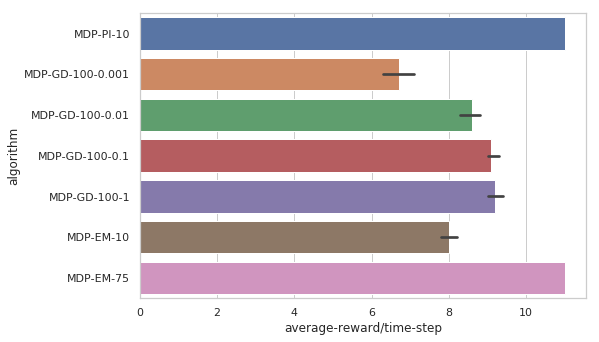

In [14]:
'''
code for plotting a good graph
'''
sns.set(rc={'figure.figsize':(8,5.25)})
sns.set_style('whitegrid')
sns.barplot(y="algorithm",
              x="average-reward/time-step",
              data=log,
              ci=90)
plt.savefig('exp_sp_result.png', dpi=600, bbox_inches="tight")